# コンテンツ
- 埋め込み
- アテンションメカニズム
- 表現学習

# 前提知識
- gpt2はランク３のテンソルをインプットにとる。(n_batch, n_token, n_dim)
- 1次元目はバッチ数、2次元目は(最大)入力トークン数、3次元目はトークンを埋め込みベクトルに変換したときの要素数(768? 1600?)
- gpt2にはボディとヘッドという区別がある
- gpt2ボディのアウトプットはインプットと同様にランク3のテンソルであり、size()もまったく同じである。
- つまりモデルを経過することで、トークンの埋め込み表現が変化するということ。

# 埋め込み(embedding)
## どのようにトークン(整数値)を埋め込み(768次元ベクトル)に変換しているのか？
- `torch.nn.Embedding(input: list)`の中身を知りたい

## pytorchの実装調べた結果
- モデル作成時に(n_vocaburary+1, n_dim)の行列をランダム(標準正規分布から値をサンプリング)に作成して該当するトークンのベクトルを返している。
- この行列を埋め込み行列といい、バッチ単位で学習するごとにパラメータの値は変化していく
- すべてのパラメータは損失関数で微分可能である必要があるため、本来はone-hotベクトルに行列をかける処理が必要だが、実際の処理では計算量の削減のために埋め込み行列の該当する行を参照して返している

## 関連ソース(pytorch)
- [sparse.py](https://github.com/pytorch/pytorch/blob/main/torch/nn/modules/sparse.py#L13)
- [functional.py](https://github.com/pytorch/pytorch/blob/main/torch/nn/functional.py#L2127)
- [decomposition.py](https://github.com/pytorch/pytorch/blob/main/torch/_decomp/decompositions.py#L1083)

# アテンションメカニズム
- アテンションとはgpt2のモデル内で繰り返し使用されているattention層の機能のこと

まずは実装からみてみる

In [ ]:
import torch
from transformers import AutoModel

model_ckpt = "gpt2"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)
# bert = AutoModel.from_pretrained(bert_ckpt).to(device)
# 事前学習済みモデルをhugging faceからダウンロードし、
# メモリ上にモデルインスタンスを初期化している
# to(device)のくだりは時間があれば後ほど解説
# 実行するのがCPUかGPUかによってメモリ配置が異なるということ

gpt2 = model

In [ ]:
print(getattr(gpt2, '__call__'))

この中の`GPT2Attention`クラスの実装を理解することが今回の主要目的。

まずは全体像の把握から。

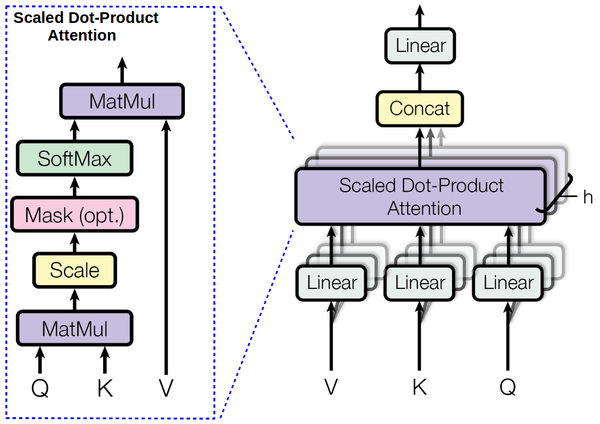

- 入力にkey,value,queryをつっこんでいるっぽい


In [ ]:
# 次は実装
# Transformersライブラリの実装を一部改変
import math
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter

# 以下最初期のTransformersライブラリのアテンション実装を引用
class Attention(nn.Module):
    def __init__(self, nx, n_ctx, n_head, scale=False):
        super(Attention, self).__init__()
        n_state = nx  # in Attention: n_state=768 (nx=n_embd)
        # [switch nx => n_state from Block to Attention to keep identical to TF implem]
        assert n_state % n_head == 0
        self.register_buffer('b', torch.tril(torch.ones(n_ctx, n_ctx)).view(1, 1, n_ctx, n_ctx))
        self.n_head = n_head
        self.split_size = n_state
        self.scale = scale
        self.c_attn = Conv1D(n_state * 3, 1, nx)
        self.c_proj = Conv1D(n_state, 1, nx)
        # self.attn_dropout = nn.Dropout(cfg.attn_pdrop)
        # self.resid_dropout = nn.Dropout(cfg.resid_pdrop)

    def forward(self, x):
        x = self.c_attn(x)
        query, key, value = x.split(self.split_size, dim=2)
        # マルチヘッド対応に相当する行はコメントアウトした
        # query = self.split_heads(query)
        # key = self.split_heads(key, k=True)
        # value = self.split_heads(value)
        a = self._attn(query, key, value)
        # a = self.merge_heads(a)
        a = self.c_proj(a)
        a = self.resid_dropout(a)
        return a

    # scaled dot product
    def _attn(self, q, k, v):
        w = torch.matmul(q, k)
        if self.scale:
            w = w / math.sqrt(v.size(-1))
        w = w * self.new_method() + -1e9 * (1 - self.b)  # TF implem method: mask_attn_weights
        w = nn.Softmax(dim=-1)(w)
        w = self.attn_dropout(w)
        return torch.matmul(w, v)

class Conv1D(nn.Module):
    def __init__(self, nf, rf, nx):
        super(Conv1D, self).__init__()
        self.rf = rf
        self.nf = nf
        if rf == 1:  # faster 1x1 conv
            w = torch.empty(nx, nf)
            nn.init.normal_(w, std=0.02)
            self.w = Parameter(w)
            self.b = Parameter(torch.zeros(nf))
        else:  # was used to train LM
            raise NotImplementedError

    def forward(self, x):
        if self.rf == 1:
            size_out = x.size()[:-1] + (self.nf,)
            x = torch.addmm(self.b, x.view(-1, x.size(-1)), self.w)
            x = x.view(*size_out)
        else:
            raise NotImplementedError
        return x

### 実装の概略
#### $c\_attn(x):= \boldsymbol{W}\boldsymbol{x}+\boldsymbol{b}$
![](../images/pre_attention.png)
- 全結合層。埋め込みの次元数を3倍に拡張する線形変換の後に平行移動。
- パラメータは(3n,n)の行列$\boldsymbol{W}$と$3n$次元列ベクトル$\boldsymbol{b}$はで特徴づけられている。つまり合計パラメータ数は$3n*(n+1)$
- 出力の射影をとったものをquery,key,valueに割り当て。それぞれの次元はもとのxと同じになるようにする。射影をとるので線形変換。
- $\boldsymbol{W}$と$\boldsymbol{b}$を決めるとquery,key,valueが一意に決まる。
- query, key, valueの情報でもとの埋め込み情報を過不足なく表現できている。

#### $\_attn(\boldsymbol{q_i}, \boldsymbol{K}, \boldsymbol{V}):= \sum_{j=0}^{N-1}(softmax(s_{i,j}) \boldsymbol{v_{j}}) $　$where\ s_{i,j} = \boldsymbol{q_i}・\boldsymbol{k_j}$
![](../images/attn.png)
- $s_{i,j}$は2つのベクトルの類似度を表す実数
- 類似度は内積で表現している
- $j>i$のときは$s_{i,j}=-\infty$とする
- 類似度をソフトマックスで正規化してそれをvalueの重みとする。$s_{i,j}=-\infty$のときはソフトマックス値は0になる


#### $c\_proj(a):= \boldsymbol{W}\boldsymbol{x}+\boldsymbol{b}$
- ふたたび全結合層。こんどは入力ベクトルの次元と出力ベクトルの次元が同じ。

#### $resid\_dropout(a)$
- ドロップアウト処理。省略。

## Attention層の意味
- Attention層を通じて各トークンの埋め込みベクトルを更新している
- この中に出てきた全てのパラメータ行列の各要素が学習を通じて<いい感じに>更新される

## Attention層の可視化
- 可視化ツールで各トークン同士の類似度をグラフにして見てみることにする
    - [bertviz](https://github.com/jessevig/bertviz)

In [ ]:
!pip install bertviz
from bertviz.transformers_neuron_view import GPT2Model, GPT2Tokenizer
from bertviz.neuron_view import show

In [ ]:
model_type = 'gpt2'
model_version = 'gpt2'
model = GPT2Model.from_pretrained(model_version)
tokenizer = GPT2Tokenizer.from_pretrained(model_version)
text = "I ate an apple on the horse, it was so delicious."
show(model, model_type, tokenizer, text, display_mode='light')

In [ ]:
from transformers import AutoTokenizer, AutoModel, utils
from bertviz import model_view
utils.logging.set_verbosity_error()  # Suppress standard warnings

model_name = "gpt2"  # Find popular HuggingFace models here: https://huggingface.co/models
input_text = text  
model = AutoModel.from_pretrained(model_name, output_attentions=True)  # Configure model to return attention values
tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
model_view(attention, tokens)  # Display model view

# 表現学習
## attentionはモデルの中でどのように機能しているのか
- ひとつのベクトル空間に存在する複数のベクトルに線形変換Tを行っても、それは表現が変わったというだけで実際の関係は保持される。つまりそれは基底の係数に過ぎないので、基底が変わると係数も変わるという話。
- n個のトークン埋め込みベクトルにそれぞれ同じ線形変換をほどこすことで、representationを変えている。
- attention層ではこの線形変換の仕方を学習することでトークンデータの最適な表現方法を学習している
- データの最適な表現方法を学習することを表現学習とよぶ
- いろいろわからないことがおおい
    - 実装<わかる>、意図<まあわかる>、どのように機能しているか<まったくわからない>
    - 事前学習済みモデルの埋め込み行列は、これまでのインプットの大量の文章を基にしてそれぞれのトークン表現を学習したものなので、アテンション層ブロックを通さず、これ単体でもかなり価値のある情報になっている？
    - アテンション層は、トークン同士のつながりを学習することに特化している？
    - 次トークンの予測タスクとembeddingの関連が全くわからない。表現学習が完全におこなわれた場合、埋め込みには次トークン情報も含まれているのか？

# 参考文献・URL
- [機械学習エンジニアのためのTransformers](https://www.amazon.co.jp/dp/4873119952)
    - おもに3章 Transformerの詳細
- [【深層学習】Transformer - Multi-Head Attentionを理解してやろうじゃないの【ディープラーニングの世界vol.28】](https://www.youtube.com/watch?v=50XvMaWhiTY)